<a href="https://colab.research.google.com/github/TranThanhChien/trafficsignregco/blob/main/training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import random
# from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/phan_loai_bbgt/mydata" 
labelFile = "/content/drive/MyDrive/phan_loai_bbgt/labels.csv" 
batch_size_val = 50  
# steps_per_epoch_val = 2000
epochs_val = 10
imageDimesions = (32, 32, 3)
testRatio = 0.2  # if 1000 images split will 200 for testing
validationRatio = 0.2  # if 1000 images 20% of remaining 800 will be 160 for validation

In [ ]:
count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:", len(myList))
noOfClasses = len(myList)
print("Importing Classes.....")
for x in range(0, len(myList)):
    myPicList = os.listdir(path + "/" + str(count))
    for y in myPicList:
        curImg = cv2.imread(path + "/" + str(count) + "/" + y)
        images.append(curImg)
        classNo.append(count)
    print(count, end=" ")
    count += 1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Total Classes Detected: 9
Importing Classes.....
0 1 2 3 4 5 6 7 8  


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    images, classNo, test_size=testRatio
)
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=validationRatio
)

In [ ]:
print("Data Shapes")
print("Train", end="")
print(X_train.shape, y_train.shape)
print("Validation", end="")
print(X_validation.shape, y_validation.shape)
print("Test", end="")
print(X_test.shape, y_test.shape)


Data Shapes
Train(384, 32, 32, 3) (384,)
Validation(96, 32, 32, 3) (96,)
Test(120, 32, 32, 3) (120,)


In [ ]:
data = pd.read_csv(labelFile)
print("data shape ", data.shape, type(data))

data shape  (9, 2) <class 'pandas.core.frame.DataFrame'>


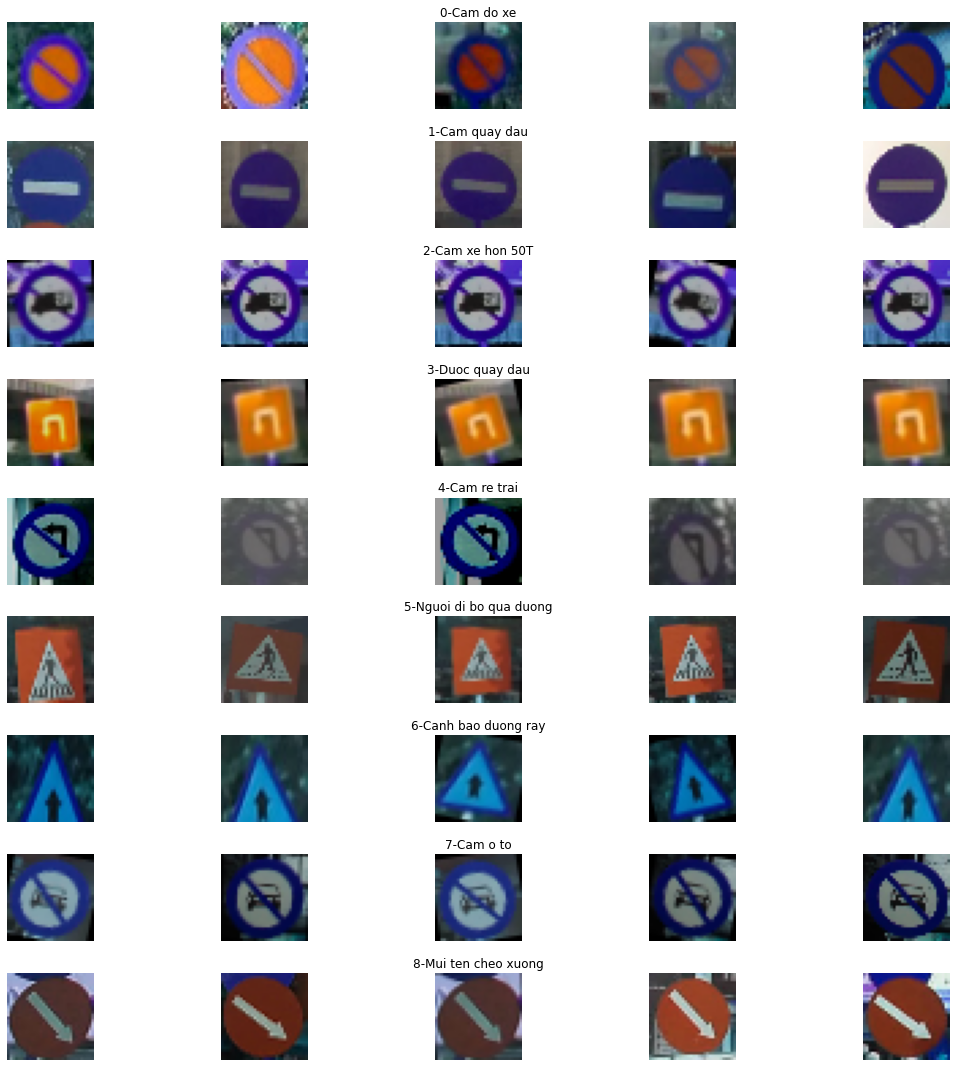

In [ ]:
num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(15, 15))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(
            x_selected[random.randint(0, len(x_selected) - 1), :, :],
            cmap=plt.get_cmap("gray"),
        )
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["Name"])
            num_of_samples.append(len(x_selected))


[97, 88, 15, 14, 20, 43, 21, 25, 61]


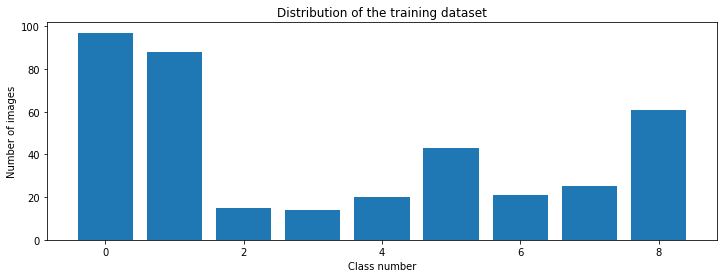

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [ ]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img) 
    img = equalize(img) 
    img = img / 255  
    return img

In [ ]:
X_train = np.array(
    list(map(preprocessing, X_train))
)  # TO IRETATE AND PREPROCESS ALL IMAGES
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))
# ADD A DEPTH OF 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(
    X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1
)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [ ]:
y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

In [ ]:
def myModel():
    no_Of_Filters = 60
    size_of_Filter = (5,5)     
    size_of_Filter2 = (3,3)
    size_of_pool = (2,2) 
    no_Of_Nodes = 500  
    model = Sequential()
    model.add(
        (
            Conv2D(
                no_Of_Filters,
                size_of_Filter,
                input_shape=(imageDimesions[0], imageDimesions[1], 1),
                activation="relu",
            )
        )
    )  # imagedimension change
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation="relu")))
    model.add(MaxPooling2D(pool_size=size_of_pool))  

    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation="relu")))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation="relu")))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(no_Of_Nodes, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation="softmax"))
    
    model.compile(Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
model = myModel()
print(model.summary())
history = model.fit(X_train, y_train, batch_size=batch_size_val, epochs=epochs_val, validation_data=(X_test, y_test))
model.save("/content/drive/MyDrive/phan_loai_bbgt/my_model.h5")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 60)        1560      
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 60)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                  

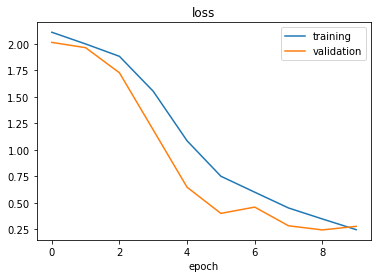

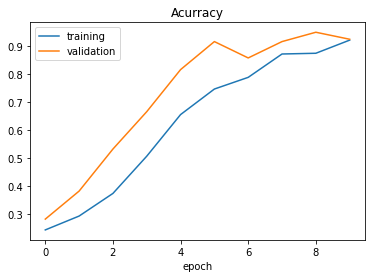

Test Score: 0.27922070026397705
Test Accuracy: 0.925000011920929


In [ ]:
plt.figure(1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["training", "validation"])
plt.title("loss")
plt.xlabel("epoch")
plt.figure(2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["training", "validation"])
plt.title("Acurracy")
plt.xlabel("epoch")
plt.show()
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])